# **Car Detection** 


In [1]:
import matplotlib.image as mpimg
import numpy as np
import cv2
from skimage.feature import hog

import matplotlib.pyplot as plt
import glob
import time
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler

from helper_functions import *
# NOTE: the next import is only valid for scikit-learn version <= 0.17
# for scikit-learn >= 0.18 use:
# from sklearn.model_selection import train_test_split
from sklearn.cross_validation import train_test_split

/Users/ravindar/anaconda/anaconda/envs/keras/lib/python3.5/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
def train(X_train, y_train, X_test, y_test):
    # Use a linear SVC
    clf = LinearSVC()
    # Check the training time for the SVC
    t = time.time()
    clf.fit(X_train, y_train)
    t2 = time.time()
    print(round(t2 - t, 2), 'Seconds to train SVC...')
    # Check the score of the SVC
    print('Test Accuracy of SVC = ', round(clf.score(X_test, y_test), 4))
    # Check the prediction time for a single sample
    t = time.time()
    return clf;

# Read in cars and notcars
cars = glob.glob('vehicles/*/*.png')
notcars = glob.glob('non-vehicles/*/*.png')
print('Total vehicles: {}, Total non-vehicles: {}'.format(len(cars), len(notcars)))

### TODO: Tweak these parameters and see how the results change.
color_space = 'RGB'  # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 9  # HOG orientations
pix_per_cell = 8  # HOG pixels per cell
cell_per_block = 2  # HOG cells per block
hog_channel = "ALL"  # Can be 0, 1, 2, or "ALL"
spatial_size = (32, 32)  # Spatial binning dimensions
hist_bins = 32  # Number of histogram bins
spatial_feat = True  # Spatial features on or off
hist_feat = True  # Histogram features on or off
hog_feat = True  # HOG features on or off
y_start_stop = [360, None]  # Min and max in y to search in slide_window()

print('Extracting car features with color_space {}, orient {}, hog pixel/cell {}, cell/block {}, hog channel {}'.format(color_space, orient, pix_per_cell, cell_per_block, hog_channel))
print('spatial_size {}, hist_bins {}, spatial_feat {}, hist_feat {}, hog_feat {}, y_start_stop {}'.format(spatial_size, hist_bins, spatial_feat, hist_feat, hog_feat, y_start_stop))
car_features = extract_features(cars, color_space=color_space,
                                spatial_size=spatial_size, hist_bins=hist_bins,
                                orient=orient, pix_per_cell=pix_per_cell,
                                cell_per_block=cell_per_block,
                                hog_channel=hog_channel, spatial_feat=spatial_feat,
                                hist_feat=hist_feat, hog_feat=hog_feat)
print('Extracting non-car features with color_space {}, orient {}, hog pixel/cell {}, cell/block {}, hog channel {}'.format(color_space, orient, pix_per_cell, cell_per_block, hog_channel))
print('spatial_size {}, hist_bins {}, spatial_feat {}, hist_feat {}, hog_feat {}, y_start_stop {}'.format(spatial_size, hist_bins, spatial_feat, hist_feat, hog_feat, y_start_stop))
notcar_features = extract_features(notcars, color_space=color_space,
                                   spatial_size=spatial_size, hist_bins=hist_bins,
                                   orient=orient, pix_per_cell=pix_per_cell,
                                   cell_per_block=cell_per_block,
                                   hog_channel=hog_channel, spatial_feat=spatial_feat,
                                   hist_feat=hist_feat, hog_feat=hog_feat)

X = np.vstack((car_features, notcar_features)).astype(np.float64)
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)
# Apply the scaler to X
scaled_X = X_scaler.transform(X)

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))

# Split up data into randomized training and test sets
print('Creating training and test set')
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    scaled_X, y, test_size=0.2, random_state=rand_state)

svc = train(X_train, y_train, X_test, y_test)

print('Using:', orient, 'orientations', pix_per_cell,
      'pixels per cell and', cell_per_block, 'cells per block')
print('Feature vector length:', len(X_train[0]))
print('svc is trained')

Total vehicles: 8792, Total non-vehicles: 8968
Extracting car features with color_space RGB, orient 9, hog pixel/cell 8, cell/block 2, hog channel ALL
spatial_size (32, 32), hist_bins 32, spatial_feat True, hist_feat True, hog_feat True, y_start_stop [360, None]
Extracting non-car features with color_space RGB, orient 9, hog pixel/cell 8, cell/block 2, hog channel ALL
spatial_size (32, 32), hist_bins 32, spatial_feat True, hist_feat True, hog_feat True, y_start_stop [360, None]
Creating training and test set
31.97 Seconds to train SVC...
Test Accuracy of SVC =  0.9803
Using: 9 orientations 8 pixels per cell and 2 cells per block
Feature vector length: 8460
svc is trained


1


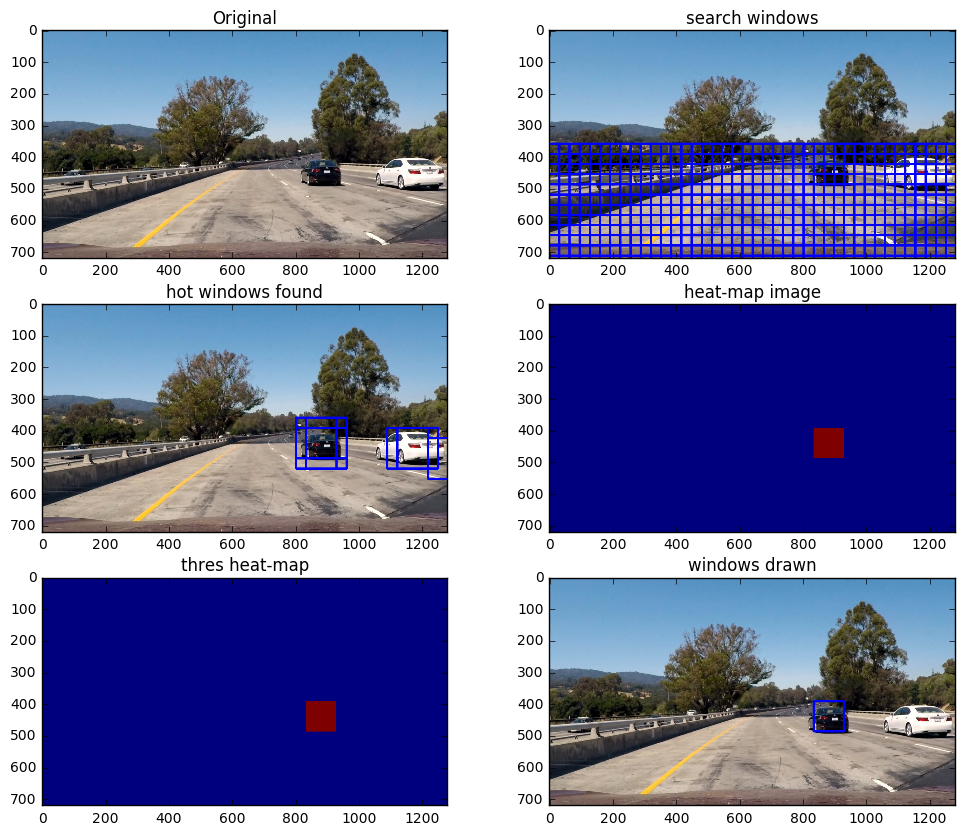

In [15]:
def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    bboxes =[]
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        bboxes.append(bbox)
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img, bboxes

def add_heat(image, bbox_list):
    #print(image.shape[0], image.shape[1])
    heatmap = np.zeros_like(image[:,:,0]).astype(np.float32)
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1
#         print(box[0][1], box[1][1], box[0][0], box[1][0])
#         print(heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]])

    # Return updated heatmap
    return heatmap

def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

from skimage import data, util

test_image = mpimg.imread('test_images/test1.jpg')
draw_image = np.copy(test_image)

# Uncomment the following line if you extracted training
# data from .png images (scaled 0 to 1 by mpimg) and the
# image you are searching is a .jpg (scaled 0 to 255)
test_image = test_image.astype(np.float32)/255

# small_windows = slide_window(test_image, x_start_stop=[None, None], y_start_stop=[360, 500],
#                        xy_window=(64, 64), xy_overlap=(0.50, 0.50))
small_windows = slide_window(test_image, x_start_stop=[800, 1100], y_start_stop=[360, 500],
                           xy_window=(96, 96), xy_overlap=(0.85, 0.85))

# medium_windows = slide_window(test_image, x_start_stop=[None, None], y_start_stop=[400, 600],
#                        xy_window=(96, 96), xy_overlap=(0.50, 0.50))

large_windows = slide_window(test_image, x_start_stop=[None, None], y_start_stop=[360, 700],
                       xy_window=(128, 128), xy_overlap=(0.75, 0.75))

windows = []
# for w in small_windows:
#     windows.append(w)

# for w in medium_windows:
#     windows.append(w)

for w in large_windows:
    windows.append(w)

search_window_image = draw_boxes(draw_image, windows)

hot_windows = search_windows(test_image, windows, svc, X_scaler, color_space=color_space,
                             spatial_size=spatial_size, hist_bins=hist_bins,
                             orient=orient, pix_per_cell=pix_per_cell,
                             cell_per_block=cell_per_block,
                             hog_channel=hog_channel, spatial_feat=spatial_feat,
                             hist_feat=hist_feat, hog_feat=hog_feat)

hot_windows_image = draw_boxes(draw_image, hot_windows)

heat_map_image = add_heat(draw_image, hot_windows)
thresholded_image = apply_threshold(heat_map_image, 2)

from scipy.ndimage.measurements import label

labels = label(thresholded_image)
print(labels[1])

window_img, bbox_list = draw_labeled_bboxes(draw_image, labels)

f, ((ax1, ax2), (ax3, ax4), (ax5, ax6)) = plt.subplots(3, 2, figsize=(12, 10))
ax1.imshow(test_image)
ax1.set_title('Original', fontsize=12)

ax2.imshow(search_window_image)
ax2.set_title('search windows', fontsize=12)

ax3.imshow(hot_windows_image)
ax3.set_title('hot windows found', fontsize=12)

ax4.imshow(heat_map_image)
ax4.set_title('heat-map image', fontsize=12)

ax5.imshow(thresholded_image)
ax5.set_title('thres heat-map', fontsize=12)

ax6.imshow(window_img)
ax6.set_title('windows drawn', fontsize=12)

plt.show()

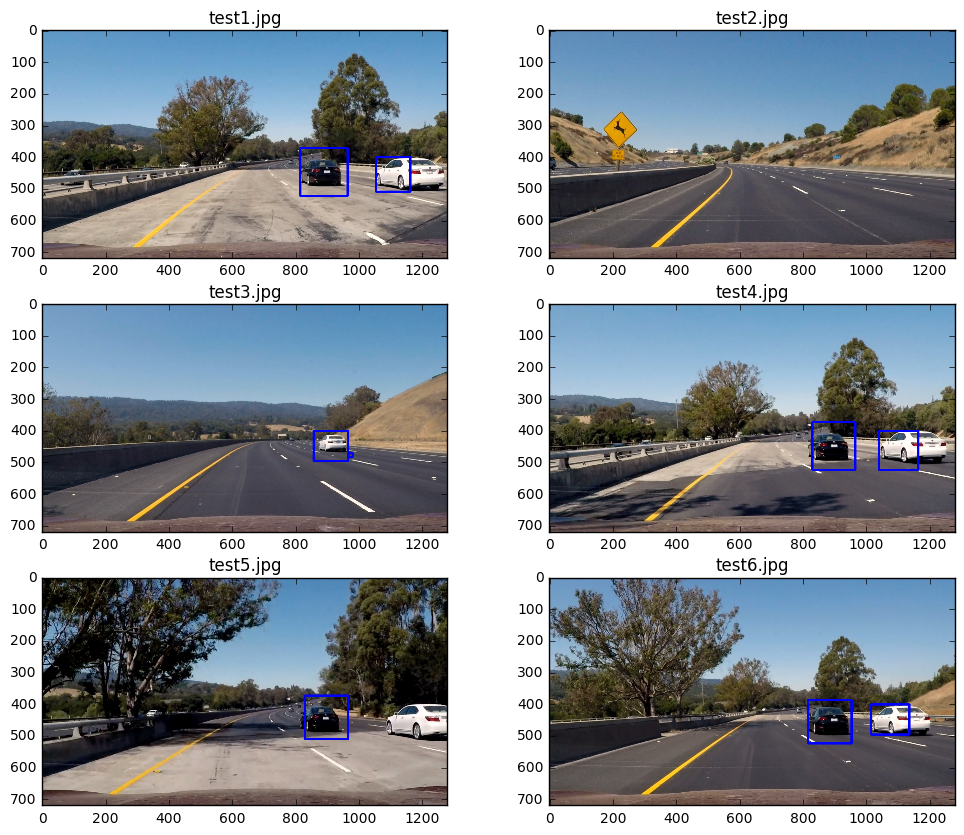

In [30]:
from scipy.ndimage.measurements import label

from moviepy.editor import VideoFileClip

NUM_OF_FRAMES = 5
COUNTER = 0 

class Frame:
    def __init__(self):
        self.frame_count = 1
        self.prev_labels = []
        self.saved_bboxes = []
    
    def set_frame_labels(self, labels):
        self.prev_labels = labels
    
    def get_bboxes(self):
        return self.saved_bboxes
    
    def next_frame_boxes_valid(self, new_labels):
        bboxes = []
        for new_car_number in range(1, new_labels[1]+1):
            new_nonzero = (new_labels[0] == new_car_number).nonzero()
            # Identify x and y values of those pixels
            new_nonzeroy = np.array(new_nonzero[0])
            new_nonzerox = np.array(new_nonzero[1])
            new_bbox = ((np.min(new_nonzerox), np.min(new_nonzeroy)), (np.max(new_nonzerox), np.max(new_nonzeroy)))
            for old_car_number in range(1, self.prev_labels[1]+1):
                old_nonzero = (self.prev_labels[0] == old_car_number).nonzero()
                # Identify x and y values of those pixels
                old_nonzeroy = np.array(new_nonzero[0])
                old_nonzerox = np.array(new_nonzero[1])
                old_bbox = ((np.min(old_nonzerox), np.min(old_nonzeroy)), (np.max(old_nonzerox), np.max(old_nonzeroy)))
                
                p1_old, p2_old = old_bbox
                x1 = int((p1_old[0] + p2_old[0]) / 2)
                y1 = int((p1_old[1] + p2_old[1]) / 2)
                #print(x1, y1)

                p1_new, p2_new = new_bbox
                x2 = int((p1_new[0] + p2_new[0]) / 2)
                y2 = int((p1_new[1] + p2_new[1]) / 2)
                #print(x2, y2)
                
                #print('compare boxes')
                if (np.sqrt((x1-x2)**2 + (y1-y2)**2) < 50):
                    #print('append old box')
                    bboxes.append(old_bbox)
        self.saved_bboxes = bboxes
        return bboxes
    
def get_labeled_bboxes(labels):
    # Iterate through all detected cars
    bboxes =[]
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        bboxes.append(bbox)
        # Draw the box on the image
        #cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return bboxes
    
def pipeline(image, frame, test_mode=0):
    draw_image = np.copy(image)

    # Since the training data was extracted from .png images (scaled 0 to 1 by mpimg) and the
    # image I am searching is a .jpg (scaled 0 to 255)
    test_image = image.astype(np.float32)/255

    small_windows = slide_window(test_image, x_start_stop=[800, 1100], y_start_stop=[360, 500],
                           xy_window=(96, 96), xy_overlap=(0.85, 0.85))

#     medium_windows = slide_window(test_image, x_start_stop=[800, None], y_start_stop=[400, 600],
#                            xy_window=(96, 96), xy_overlap=(0.75, 0.75))

    large_windows = slide_window(test_image, x_start_stop=[None, None], y_start_stop=[360, 700],
                           xy_window=(128, 128), xy_overlap=(0.65, 0.65))

    windows = []
    for w in small_windows:
        windows.append(w)

#     for w in medium_windows:
#         windows.append(w)

    for w in large_windows:
        windows.append(w)

    #search_window_image = draw_boxes(draw_image, windows)

    hot_windows = search_windows(test_image, windows, svc, X_scaler, color_space=color_space,
                                 spatial_size=spatial_size, hist_bins=hist_bins,
                                 orient=orient, pix_per_cell=pix_per_cell,
                                 cell_per_block=cell_per_block,
                                 hog_channel=hog_channel, spatial_feat=spatial_feat,
                                 hist_feat=hist_feat, hog_feat=hog_feat)

    #hot_windows_image = draw_boxes(draw_image, hot_windows)

    heat_map_image = add_heat(draw_image, hot_windows)
    thresholded_image = apply_threshold(heat_map_image, 2)

    labels = label(thresholded_image)
    
    if test_mode == 1:
        bbox_list = get_labeled_bboxes(labels)
        for bbox in bbox_list:
            # Draw a rectangle given bbox coordinates
            cv2.rectangle(draw_image, bbox[0], bbox[1], (0, 0, 255), 6)
        return draw_image
        
    if frame.frame_count == 2:
        frame.frame_count = 1
        bbox_list = frame.next_frame_boxes_valid(labels)
    else:
        frame.set_frame_labels(labels)
        frame.frame_count += 1
    
    bboxes = frame.get_bboxes()
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(draw_image, bbox[0], bbox[1], (0, 0, 255), 6)

    return draw_image

frame = Frame()
test_image1 = mpimg.imread('test_images/test1.jpg')
test_image2 = mpimg.imread('test_images/test2.jpg')
test_image3 = mpimg.imread('test_images/test3.jpg')
test_image4 = mpimg.imread('test_images/test4.jpg')
test_image5 = mpimg.imread('test_images/test5.jpg')
test_image6 = mpimg.imread('test_images/test6.jpg')
boxed_image1 = pipeline(test_image1, frame, 1)
boxed_image2 = pipeline(test_image2, frame, 1)
boxed_image3 = pipeline(test_image3, frame, 1)
boxed_image4 = pipeline(test_image4, frame, 1)
boxed_image5 = pipeline(test_image5, frame, 1)
boxed_image6 = pipeline(test_image6, frame, 1)
f, ((ax1, ax2), (ax3, ax4), (ax5, ax6)) = plt.subplots(3, 2, figsize=(12, 10))
ax1.imshow(boxed_image1)
ax1.set_title('test1.jpg', fontsize=12)

ax2.imshow(boxed_image2)
ax2.set_title('test2.jpg', fontsize=12)

ax3.imshow(boxed_image3)
ax3.set_title('test3.jpg', fontsize=12)

ax4.imshow(boxed_image4)
ax4.set_title('test4.jpg', fontsize=12)

ax5.imshow(boxed_image5)
ax5.set_title('test5.jpg', fontsize=12)

ax6.imshow(boxed_image6)
ax6.set_title('test6.jpg', fontsize=12)

plt.show()

In [31]:
from moviepy.editor import VideoFileClip

def process_image():
    frame = Frame()
    return (lambda img: pipeline(img, frame))

video_output = "project_video_output.mp4"
clip1 = VideoFileClip("project_video.mp4")
clip = clip1.fl_image(process_image())
%time clip.write_videofile(video_output, audio=False)

[MoviePy] >>>> Building video project_video_output.mp4
[MoviePy] Writing video project_video_output.mp4


100%|█████████▉| 1260/1261 [30:41<00:01,  1.32s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_output.mp4 

CPU times: user 1h 56min 28s, sys: 3min 20s, total: 1h 59min 48s
Wall time: 30min 42s
